# SITCOM-1118 Slewing in Azimuth Analysis - Positioning

To analyze the positioning system after a slew in azimuth

This is very similar to the SITCOM-797_ims_slewing_analysis_positioning notebook, but we select slews where the TMA is moving in azimuth only. The idea is that when the TMA moves in elevation, the IMS is measuring the cell flexure which will be compensated by the hexapods and the Look Up Tables (LUT). By selecting slews where the TMA is movin in azimuth the mirror displacement should remain within the following tolerances:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree (0.0864 arcsec)
* piston less than +/- 1 micrometer

# Prepare Notebook

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from scipy.stats import linregress

from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [4]:
# Select data from a given period - Here we give a list of dates
dayObs = [20231118, 20231119, 20231120, 20231121, 20231122, 20231123, 20231124]
# dayObs = [20231220]

eventMaker = TMAEventMaker()
for i, d in enumerate(dayObs):
    if i == 0:
        events = eventMaker.getEvents(d)
    else:
        events = events + eventMaker.getEvents(d)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 1959 slews


In [5]:
# Create client to access either the idf or the usdf EFD
client = EfdClient("idf_efd")

In [6]:
pos_columns = ["xPosition", "yPosition", "zPosition"]
rot_columns = ["xRotation", "yRotation", "zRotation"]
all_columns = pos_columns + rot_columns

# Compute intermediate values that will be used later in the analysis

* Loop over all the slews
* Compute relevant quantities from the EFD
* Store results in a dataframe in order to plot them later
***
For each slew we record the following quantities:
 * **i_slew**: Slew number
 * **duration**: Slew duration
 * **x_mean, y_mean, z_mean**: Average positions
 * **x_sigma, y_sigma, z_sigma**: Sigma on positions
 * **R_x_mean, R_y_mean, R_z_mean**: Average rotations
 * **Rx_sigma, Ry_sigma, Rz_sigma**: Sigma on rotations
 * **dx_max, dy_max, dz_max**: Maximum excursion in position w.r.t. initial position
 * **R_dx_max, R_dy_max, R_dz_max**: Maximum excursion in rotation w.r.t. intitial rotation angle
 * **x_before, y_before, z_before**: Position before slew averaged over a small delta t)
 * **R_x_before, R_y_before, R_z_before**: Rotation angle before slew averaged over a small delta t)
 * **x_after, y_after, z_after**: Position after slew averaged over a small delta t)
 * **R_x_after, R_y_after, R_z_after**: Rotation angle after slew averaged over a small delta t)
 * **start_ele, end_ele**: Elevation angle at the beginning and at the end of the slew
 * **start_azi, end_azi**: Azimuth angle at the beginning and at the end of the slew
 * **speed_ele**: Elevation speed
 * **slew_end**: Timestamp when slew ends

In [62]:
# define a time window to compute the average mirror position before and after the slews
# also define a settle time after the slew before checking the mirror position
settle_t = 4
delta_t = 2
dt_begin = time.TimeDelta(-delta_t, format="sec")
dt_end = time.TimeDelta(delta_t, format="sec")
dt_settle = time.TimeDelta(settle_t, format="sec")

results = pd.DataFrame(
    columns=[
        "i_slew",
        "duration",
        "x_mean",
        "y_mean",
        "z_mean",
        "x_sigma",
        "y_sigma",
        "z_sigma",
        "R_x_mean",
        "R_y_mean",
        "R_z_mean",
        "Rx_sigma",
        "Ry_sigma",
        "Rz_sigma",
        "dx_max",
        "dy_max",
        "dz_max",
        "R_dx_max",
        "R_dy_max",
        "R_dz_max",
        "x_before",
        "y_before",
        "z_before",
        "R_x_before",
        "R_y_before",
        "R_z_before",
        "x_after",
        "y_after",
        "z_after",
        "R_x_after",
        "R_y_after",
        "R_z_after",
        "start_ele",
        "end_ele",
        "start_azi",
        "end_azi",
        "speed_ele",
        "speed_azi",
        "slew_end",
    ]
)
for i_slew, slew in enumerate(slews):
    if slew.blockInfos is None:
        print(f"No blockInfos for slew number {i_slew}")
        continue

    # Get ims data
    df_ims = getEfdData(client, "lsst.sal.MTM1M3.imsData", event=slew)
    if len(df_ims) == 0:
        print(
            f"No data for slew number: {i_slew} seqNum={slew.seqNum} , begin={slew.begin.datetime64}, end={slew.end.datetime64}"
        )
        continue

    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * u.m.to(u.mm)

    # get ims data before and after the slew
    df_ims_before = getEfdData(
        client, "lsst.sal.MTM1M3.imsData", begin=slew.begin, timespan=dt_begin
    )
    if len(df_ims_before) == 0:
        print(f"No data before slew number: {i_slew}")
        continue
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns] * u.m.to(u.mm)

    df_ims_after = getEfdData(
        client, "lsst.sal.MTM1M3.imsData", begin=slew.end + dt_settle, timespan=dt_end
    )
    if len(df_ims_after) == 0:
        print(f"No data after slew number: {i_slew}")
        continue
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns] * u.m.to(u.mm)

    # In order to avoid duplicating code for the various positions / rotations we store results in dictionaries
    # with keys equal to xPosition, yPosition, ... xRotation, ...
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before = {}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0] - df_ims[col]))

        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])

    # get elevation data
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    if len(df_ele) == 0:
        print(f"No elevation data for slew number: {i_slew}")
        continue
    pos_ele = df_ele["actualPosition"]
    start_ele = pos_ele[pos_ele.index[0]]
    end_ele = pos_ele[pos_ele.index[len(pos_ele) - 1]]
    # get speed
    speed_ele = np.mean(df_ele["demandVelocity"])

    # get azimuth data
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)
    if len(df_azi) == 0:
        print(f"No azimuth data for slew number: {i_slew}")
        continue
    pos_azi = df_azi["actualPosition"]
    start_azi = pos_azi[pos_azi.index[0]]
    end_azi = pos_azi[pos_azi.index[len(pos_azi) - 1]]
    speed_azi = np.mean(df_azi["demandVelocity"])

    # Store computed values in dataframe
    # Pandas requires the values in each rows to be passed as a flat vector
    # First we need to extract the values from the dictionaries
    vect = [
        [i_slew],
        [slew.duration],
        [mean[i] for i in pos_columns],
        [sigma[i] for i in pos_columns],
        [mean[i] for i in rot_columns],
        [sigma[i] for i in rot_columns],
        [max_diff[i] for i in pos_columns],
        [max_diff[i] for i in rot_columns],
        [mean_before[i] for i in pos_columns],
        [mean_before[i] for i in rot_columns],
        [mean_after[i] for i in pos_columns],
        [mean_after[i] for i in rot_columns],
        [start_ele],
        [end_ele],
        [start_azi],
        [end_azi],
        [speed_ele],
        [speed_azi],
        [slew.end],
    ]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat(
        [results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True
    )

No blockInfos for slew number 0
No blockInfos for slew number 1
No blockInfos for slew number 2
No blockInfos for slew number 416
No blockInfos for slew number 417
No blockInfos for slew number 418
No blockInfos for slew number 419
No blockInfos for slew number 420
No blockInfos for slew number 421
No blockInfos for slew number 422
No blockInfos for slew number 424
No blockInfos for slew number 425
No blockInfos for slew number 627
No blockInfos for slew number 628
No blockInfos for slew number 650
No blockInfos for slew number 651
No blockInfos for slew number 652
No blockInfos for slew number 674
No blockInfos for slew number 675
No blockInfos for slew number 676
No blockInfos for slew number 678
No blockInfos for slew number 679
No blockInfos for slew number 681
No blockInfos for slew number 682
No blockInfos for slew number 683
No blockInfos for slew number 684
No blockInfos for slew number 685
No blockInfos for slew number 686
No blockInfos for slew number 687
No blockInfos for sl

No data after slew number: 1082
No blockInfos for slew number 1083
No blockInfos for slew number 1084
No blockInfos for slew number 1085
No blockInfos for slew number 1086
No blockInfos for slew number 1088
No blockInfos for slew number 1089
No blockInfos for slew number 1090
No blockInfos for slew number 1091
No blockInfos for slew number 1098
No blockInfos for slew number 1099
No blockInfos for slew number 1100
No blockInfos for slew number 1114
No blockInfos for slew number 1115
No blockInfos for slew number 1116
No blockInfos for slew number 1117
No blockInfos for slew number 1132
No blockInfos for slew number 1133
No blockInfos for slew number 1154
No blockInfos for slew number 1155
No blockInfos for slew number 1156
No blockInfos for slew number 1157
No blockInfos for slew number 1159
No blockInfos for slew number 1160
No blockInfos for slew number 1161
No blockInfos for slew number 1162
No blockInfos for slew number 1163
No blockInfos for slew number 1165
No blockInfos for slew 

No data after slew number: 1174
No blockInfos for slew number 1175
No blockInfos for slew number 1176
No blockInfos for slew number 1177
No blockInfos for slew number 1191
No blockInfos for slew number 1192
No blockInfos for slew number 1193
No blockInfos for slew number 1194
No blockInfos for slew number 1195
No blockInfos for slew number 1196


No data after slew number: 1198
No blockInfos for slew number 1199
No blockInfos for slew number 1200
No blockInfos for slew number 1201
No blockInfos for slew number 1202
No blockInfos for slew number 1203
No blockInfos for slew number 1204
No blockInfos for slew number 1205
No blockInfos for slew number 1206
No blockInfos for slew number 1207
No blockInfos for slew number 1208
No blockInfos for slew number 1209
No blockInfos for slew number 1211
No blockInfos for slew number 1212
No blockInfos for slew number 1213
No blockInfos for slew number 1214
No blockInfos for slew number 1215
No blockInfos for slew number 1216
No blockInfos for slew number 1217
No blockInfos for slew number 1218
No blockInfos for slew number 1219
No blockInfos for slew number 1220
No blockInfos for slew number 1221
No blockInfos for slew number 1222
No blockInfos for slew number 1223
No blockInfos for slew number 1224
No blockInfos for slew number 1225
No blockInfos for slew number 1226
No blockInfos for slew 

No data for slew number: 1351 seqNum=66 , begin=2023-11-22T01:24:58.981821299, end=2023-11-22T01:24:58.983192444
No blockInfos for slew number 1394
No blockInfos for slew number 1395
No blockInfos for slew number 1396


No data for slew number: 1397 seqNum=155 , begin=2023-11-22T02:10:11.181326628, end=2023-11-22T02:10:11.190469742
No blockInfos for slew number 1421


No data for slew number: 1422 seqNum=204 , begin=2023-11-22T02:35:05.056590080, end=2023-11-22T02:35:05.057610989


No data for slew number: 1424 seqNum=208 , begin=2023-11-22T02:35:19.456550121, end=2023-11-22T02:35:19.468340635


No data for slew number: 1425 seqNum=209 , begin=2023-11-22T03:31:08.295118809, end=2023-11-22T03:31:08.297317505


No data for slew number: 1430 seqNum=219 , begin=2023-11-22T04:02:55.428674221, end=2023-11-22T04:02:55.438963413


No data for slew number: 1431 seqNum=220 , begin=2023-11-22T04:12:15.422843933, end=2023-11-22T04:12:15.424994946
No blockInfos for slew number 1435


No data for slew number: 1436 seqNum=229 , begin=2023-11-22T04:31:17.651277065, end=2023-11-22T04:31:17.654003620
No blockInfos for slew number 1467
No blockInfos for slew number 1468
No blockInfos for slew number 1469
No blockInfos for slew number 1470
No blockInfos for slew number 1471
No blockInfos for slew number 1472
No blockInfos for slew number 1473
No blockInfos for slew number 1474
No blockInfos for slew number 1475
No blockInfos for slew number 1476
No blockInfos for slew number 1477
No blockInfos for slew number 1478
No blockInfos for slew number 1479
No blockInfos for slew number 1480
No blockInfos for slew number 1481
No blockInfos for slew number 1482
No blockInfos for slew number 1483
No blockInfos for slew number 1484
No blockInfos for slew number 1485
No blockInfos for slew number 1486
No blockInfos for slew number 1487
No blockInfos for slew number 1488
No blockInfos for slew number 1489
No blockInfos for slew number 1490
No blockInfos for slew number 1491
No blockInf

No elevation data for slew number: 1496


No elevation data for slew number: 1497
No blockInfos for slew number 1498
No blockInfos for slew number 1499
No blockInfos for slew number 1500


No data for slew number: 1501 seqNum=35 , begin=2023-11-23T02:42:14.958534956, end=2023-11-23T02:42:14.962103605


No data for slew number: 1503 seqNum=38 , begin=2023-11-23T03:05:24.593942881, end=2023-11-23T03:05:24.594389915
No blockInfos for slew number 1505


No data for slew number: 1506 seqNum=43 , begin=2023-11-23T03:52:57.392966032, end=2023-11-23T03:52:57.394857645
No blockInfos for slew number 1508


No data for slew number: 1509 seqNum=48 , begin=2023-11-23T03:56:07.574543953, end=2023-11-23T03:56:07.574890614
No blockInfos for slew number 1511


No data for slew number: 1512 seqNum=53 , begin=2023-11-23T04:17:42.656758070, end=2023-11-23T04:17:42.669419527
No blockInfos for slew number 1534
No blockInfos for slew number 1535
No blockInfos for slew number 1536
No blockInfos for slew number 1537


No data for slew number: 1538 seqNum=102 , begin=2023-11-23T05:06:27.291920185, end=2023-11-23T05:06:27.299476862
No blockInfos for slew number 1539
No blockInfos for slew number 1540
No blockInfos for slew number 1541
No blockInfos for slew number 1542


No data for slew number: 1543 seqNum=109 , begin=2023-11-23T05:26:30.236655951, end=2023-11-23T05:26:30.237689018
No blockInfos for slew number 1569


No data for slew number: 1570 seqNum=162 , begin=2023-11-23T06:22:14.431997538, end=2023-11-23T06:22:14.443190575
No blockInfos for slew number 1595
No blockInfos for slew number 1596
No blockInfos for slew number 1597


No data for slew number: 1598 seqNum=215 , begin=2023-11-23T06:55:45.545766830, end=2023-11-23T06:55:45.548252821
No blockInfos for slew number 1599
No blockInfos for slew number 1600
No blockInfos for slew number 1601
No blockInfos for slew number 1602


No data for slew number: 1603 seqNum=222 , begin=2023-11-23T07:04:11.559740067, end=2023-11-23T07:04:11.562038898
No blockInfos for slew number 1610
No blockInfos for slew number 1611
No blockInfos for slew number 1612


No elevation data for slew number: 1613
No blockInfos for slew number 1614
No blockInfos for slew number 1615
No blockInfos for slew number 1616
No blockInfos for slew number 1617


No data for slew number: 1618 seqNum=246 , begin=2023-11-23T07:29:05.524108887, end=2023-11-23T07:29:05.524554253
No blockInfos for slew number 1639


No data for slew number: 1640 seqNum=289 , begin=2023-11-23T07:57:33.140207291, end=2023-11-23T07:57:33.149352312


No data for slew number: 1670 seqNum=349 , begin=2023-11-23T08:26:36.973331928, end=2023-11-23T08:26:36.985370159
No blockInfos for slew number 1671
No blockInfos for slew number 1674
No blockInfos for slew number 1675
No blockInfos for slew number 1676
No blockInfos for slew number 1677
No blockInfos for slew number 1678


No data for slew number: 1679 seqNum=8 , begin=2023-11-24T02:28:35.336354017, end=2023-11-24T02:28:35.337530375


No data for slew number: 1681 seqNum=11 , begin=2023-11-24T02:35:19.487652302, end=2023-11-24T02:35:19.488949060


No data for slew number: 1717 seqNum=82 , begin=2023-11-24T03:31:31.309467793, end=2023-11-24T03:31:31.314996719
No blockInfos for slew number 1739
No blockInfos for slew number 1740
No blockInfos for slew number 1741
No blockInfos for slew number 1742


No elevation data for slew number: 1743


No elevation data for slew number: 1745


No data for slew number: 1748 seqNum=139 , begin=2023-11-24T04:28:34.628042936, end=2023-11-24T04:28:34.629188061


No elevation data for slew number: 1752
No blockInfos for slew number 1753
No blockInfos for slew number 1754


No data for slew number: 1755 seqNum=150 , begin=2023-11-24T04:43:01.625501633, end=2023-11-24T04:43:01.638448000


No data for slew number: 1757 seqNum=153 , begin=2023-11-24T04:49:28.901169777, end=2023-11-24T04:49:28.907640219
No blockInfos for slew number 1765
No blockInfos for slew number 1766
No blockInfos for slew number 1767


No data for slew number: 1768 seqNum=172 , begin=2023-11-24T05:40:46.626397610, end=2023-11-24T05:40:46.627337694
No blockInfos for slew number 1770
No blockInfos for slew number 1771
No blockInfos for slew number 1772


No data for slew number: 1773 seqNum=179 , begin=2023-11-24T05:47:35.049656868, end=2023-11-24T05:47:35.051267147
No blockInfos for slew number 1774
No blockInfos for slew number 1775
No blockInfos for slew number 1776
No blockInfos for slew number 1777
No blockInfos for slew number 1778


No data for slew number: 1779 seqNum=187 , begin=2023-11-24T05:59:58.686507225, end=2023-11-24T05:59:58.687153339
No blockInfos for slew number 1785
No blockInfos for slew number 1786
No blockInfos for slew number 1787
No blockInfos for slew number 1788


No data for slew number: 1789 seqNum=204 , begin=2023-11-24T06:11:44.194581032, end=2023-11-24T06:11:44.198042393
No blockInfos for slew number 1790
No blockInfos for slew number 1791
No blockInfos for slew number 1792
No blockInfos for slew number 1793


No data for slew number: 1794 seqNum=211 , begin=2023-11-24T06:20:15.509260654, end=2023-11-24T06:20:15.510156631
No blockInfos for slew number 1796


No data for slew number: 1797 seqNum=216 , begin=2023-11-24T06:25:33.193037987, end=2023-11-24T06:25:33.194553375
No blockInfos for slew number 1883
No blockInfos for slew number 1884
No blockInfos for slew number 1885
No blockInfos for slew number 1886
No blockInfos for slew number 1888
No blockInfos for slew number 1889
No blockInfos for slew number 1890
No blockInfos for slew number 1891
No blockInfos for slew number 1892
No blockInfos for slew number 1893


No data for slew number: 1894 seqNum=402 , begin=2023-11-24T08:05:52.730243444, end=2023-11-24T08:05:52.736998558
No blockInfos for slew number 1897
No blockInfos for slew number 1898
No blockInfos for slew number 1899
No blockInfos for slew number 1900


No data for slew number: 1901 seqNum=413 , begin=2023-11-24T08:15:46.070272207, end=2023-11-24T08:15:46.071290970
No blockInfos for slew number 1906
No blockInfos for slew number 1907
No blockInfos for slew number 1908
No blockInfos for slew number 1909


No data for slew number: 1910 seqNum=428 , begin=2023-11-24T08:33:20.155961514, end=2023-11-24T08:33:20.156792164
No blockInfos for slew number 1913
No blockInfos for slew number 1914
No blockInfos for slew number 1915
No blockInfos for slew number 1916
No blockInfos for slew number 1917
No blockInfos for slew number 1918
No blockInfos for slew number 1919
No blockInfos for slew number 1920
No blockInfos for slew number 1921
No blockInfos for slew number 1922
No blockInfos for slew number 1923
No blockInfos for slew number 1924
No blockInfos for slew number 1925
No blockInfos for slew number 1926
No blockInfos for slew number 1927


No data for slew number: 1928 seqNum=6 , begin=2023-11-25T00:24:22.989422798, end=2023-11-25T00:24:23.001199484
No blockInfos for slew number 1930
No blockInfos for slew number 1931
No blockInfos for slew number 1932
No blockInfos for slew number 1933


No data for slew number: 1934 seqNum=15 , begin=2023-11-25T00:39:15.895003557, end=2023-11-25T00:39:15.897696733
No blockInfos for slew number 1935
No blockInfos for slew number 1936
No blockInfos for slew number 1937
No blockInfos for slew number 1938
No blockInfos for slew number 1939


No data for slew number: 1940 seqNum=23 , begin=2023-11-25T00:54:43.379168034, end=2023-11-25T00:54:43.382978201
No blockInfos for slew number 1942
No blockInfos for slew number 1943
No blockInfos for slew number 1944


No data for slew number: 1945 seqNum=30 , begin=2023-11-25T01:22:59.754966736, end=2023-11-25T01:22:59.756085396
No blockInfos for slew number 1947
No blockInfos for slew number 1948
No blockInfos for slew number 1949
No blockInfos for slew number 1951
No blockInfos for slew number 1952
No blockInfos for slew number 1953
No blockInfos for slew number 1954
No blockInfos for slew number 1955
No blockInfos for slew number 1956
No blockInfos for slew number 1957
No blockInfos for slew number 1958


In [12]:
print(slew.end, slew.end + dt_settle)

1700371511.9642017 1700371513.9642017


In [8]:
# As the previous query can be very long (> 30 min) to execute we can save the results dataframe in a csv file
# and reload it later - Just uncomment the relevant command

# Save results
# results.to_csv("slew2-4.csv")

# Read back results from csv file
results = pd.read_csv("slew2-4.csv")

# The analysis is starting here

We use the results dataframe to create plots

## Histogram of the difference between positions / rotations after and before the slews

**In this first analysis, we compare the positions and rotations given by the IMS at the end of the slews to the one at the start of the slew**

Outliers are excluded from the analysis but it would be interesting to investigate the origin of these outliers

Found 6 outliers xPosition (limit: 150 microns)
Found 73 outliers xRotation (limit: 0.55 arcsec)
Found 8 outliers yPosition (limit: 150 microns)
Found 24 outliers yRotation (limit: 0.55 arcsec)
Found 8 outliers zPosition (limit: 150 microns)
Found 8 outliers zRotation (limit: 0.55 arcsec)


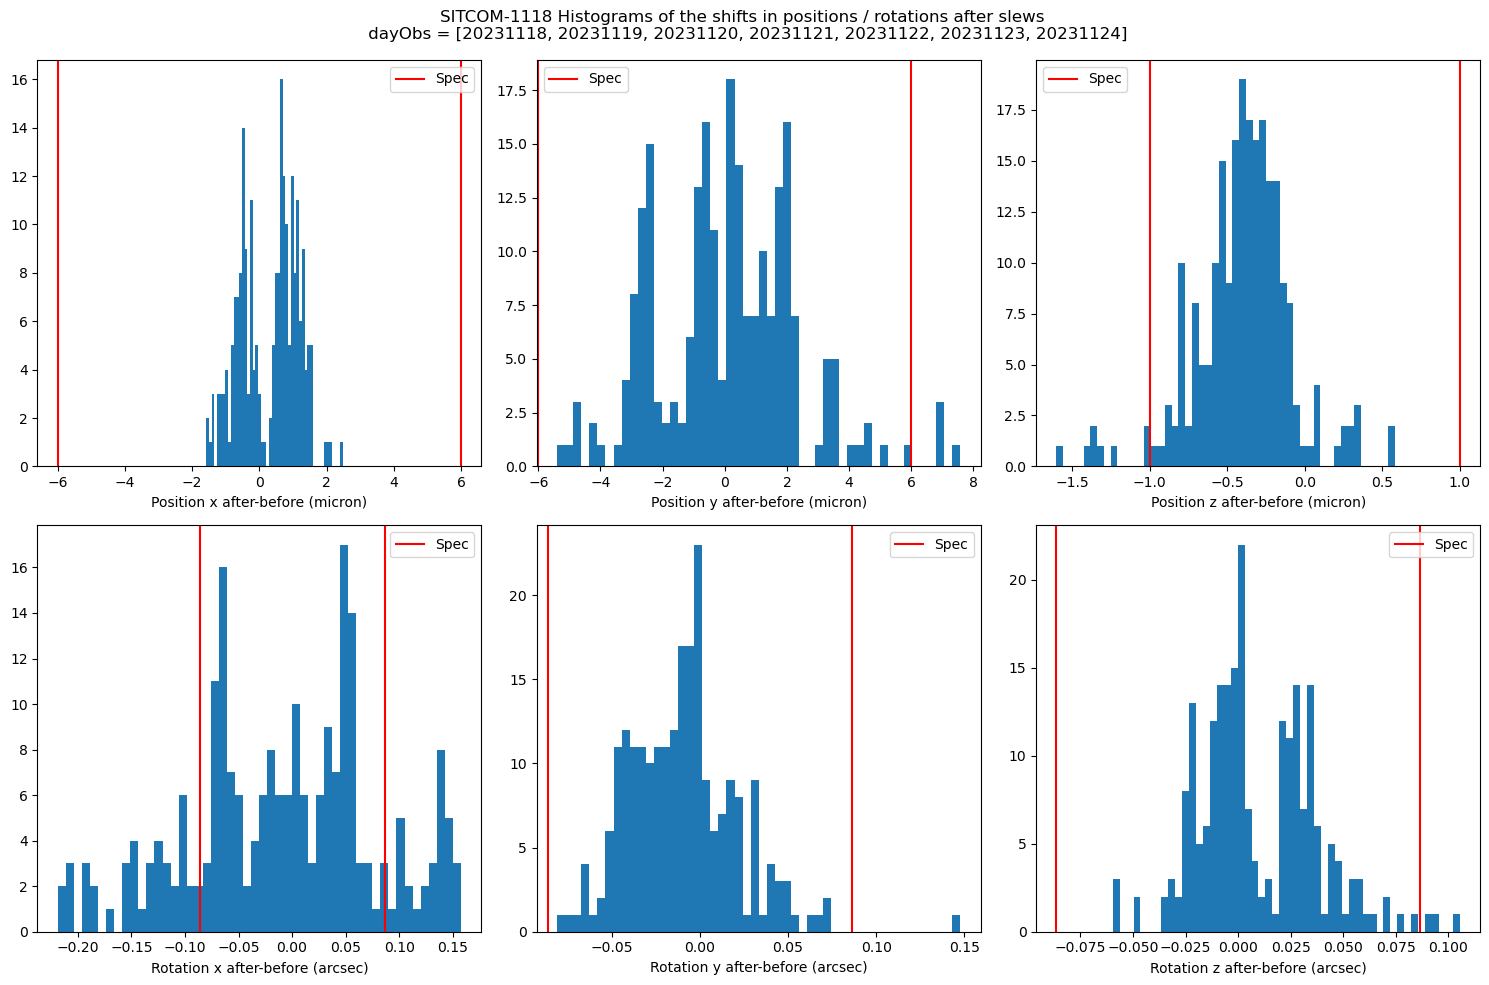

In [9]:
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for outliers
# Note that these outliers would deserve a specific study...
out_limit_pos = 150
out_limit_rot = 0.55

title = f"SITCOM-1118 Histograms of the shifts in positions / rotations after slews \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 10))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 20) & (
    abs(results["start_ele"] - results["end_ele"]) < 1
)

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")

    # add lines and labels for tolerances
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color="r", label="Spec")
        axs[0][i].axvline(-6, color="r")
        axs[0][i].legend()

        axs[1][i].axvline(0.0864, color="r", label="Spec")
        axs[1][i].axvline(-0.0864, color="r")
        axs[1][i].legend()

    else:
        axs[0][i].axvline(1, color="r", label="Spec")
        axs[0][i].axvline(-1, color="r")
        axs[0][i].legend()

        axs[1][i].axvline(0.0864, color="r", label="Spec")
        axs[1][i].axvline(-0.0864, color="r")
        axs[1][i].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

## Conclusion

The mirror displacement during slews is out of specifications, especially for what concerns the piston (z position)

## Check whether the mirror displacement is correlated to the azimuth difference ( end of slew - start of slew)


Number of azimuth only slews taken into account in the analysis: 287

Found 6 outliers for xPosition (limit: 100 microns)
Found 73 outliers for xRotation (limit: 0.55 arcsec)
Found 8 outliers for yPosition (limit: 100 microns)
Found 24 outliers for yRotation (limit: 0.55 arcsec)
Found 8 outliers for zPosition (limit: 100 microns)
Found 8 outliers for zRotation (limit: 0.55 arcsec)


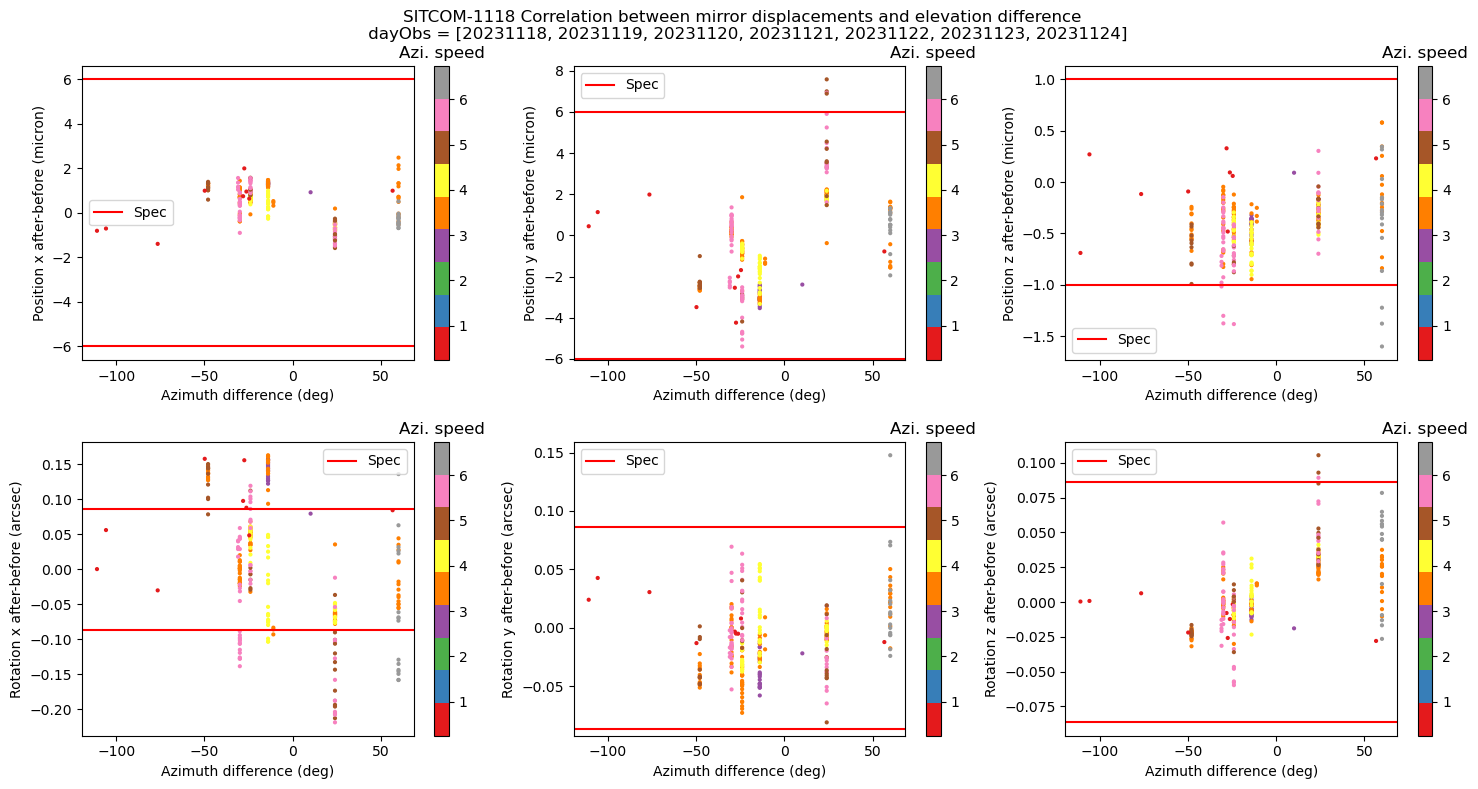

In [68]:
# The color scale represents the slew speed

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

plt.rc("text", usetex=False)

cm = matplotlib.colormaps["Set1"]

axes = ["x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-1118 Correlation between mirror displacements and elevation difference \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 1
)

print(
    f"\nNumber of azimuth only slews taken into account in the analysis: {np.sum(mask_move)}\n"
)

diff_azi = results["end_azi"] - results["start_azi"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_azi[mask], diff[mask], c=abs(results["speed_azi"][mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel("Azimuth difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Azi. speed")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        diff_azi[mask], R_diff[mask], c=abs(results["speed_azi"][mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel("Azimuth difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Azi. speed")

    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color="r", label="Spec")
        axs[0][i].axhline(-6, color="r")
        axs[0][i].legend()

        axs[1][i].axhline(0.0864, color="r", label="Spec")
        axs[1][i].axhline(-0.0864, color="r")
        axs[1][i].legend()

    else:
        axs[0][i].axhline(1, color="r", label="Spec")
        axs[0][i].axhline(-1, color="r")
        axs[0][i].legend()

        axs[1][i].axhline(0.0864, color="r", label="Spec")
        axs[1][i].axhline(-0.0864, color="r")
        axs[1][i].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

plt.savefig("1118_position_rotation_xyz.png")

## Conclusions

 - The mirror displacements plots show is a clear asymetry associated to the direction of rotation of the TMA in azimuth

## Scatter plots to check the correlations between the various mirror movements and rotations

Found 8 outliers for pair xy (limit: 100 microns)
Found 73 outliers for pair xy (limit: 0.55 arcsec)
Found 8 outliers for pair yz (limit: 100 microns)
Found 24 outliers for pair yz (limit: 0.55 arcsec)
Found 8 outliers for pair xz (limit: 100 microns)
Found 73 outliers for pair xz (limit: 0.55 arcsec)


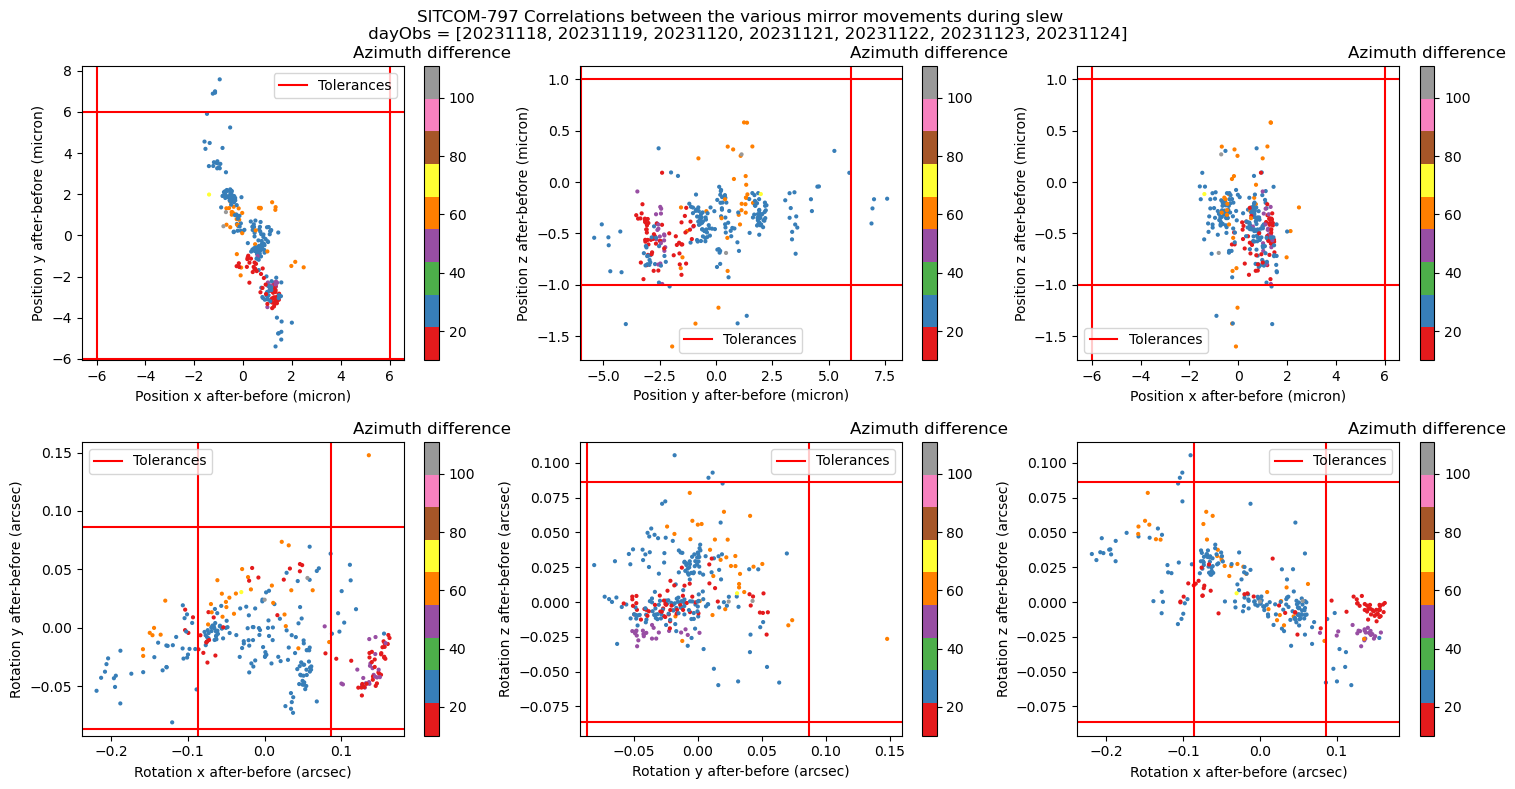

In [66]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

cm = matplotlib.colormaps["Set1"]

pairs = ["xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Correlations between the various mirror movements during slew  \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 1
)

# Azimuth change
diff_azi = results["end_azi"] - results["start_azi"]

for i in range(3):
    pair = pairs[i]

    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"]) * u.mm.to(
        u.micron
    )
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_1[mask], diff_2[mask], c=abs(diff_azi[mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Azimuth difference")

    if pair[0] == "x" or pair[0] == "y":
        axs[0][i].axvline(6, color="r", label="Tolerances")
        axs[0][i].axvline(-6, color="r")
    else:
        axs[0][i].axvline(1, color="r", label="Tolerances")
        axs[0][i].axvline(-1, color="r")

    if pair[1] == "x" or pair[1] == "y":
        axs[0][i].axhline(6, color="r")
        axs[0][i].axhline(-6, color="r")
    else:
        axs[0][i].axhline(1, color="r")
        axs[0][i].axhline(-1, color="r")

    axs[0][i].legend()

    # Rotations
    R_diff_1 = (
        results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"]
    ) * u.degree.to(u.arcsec)
    R_diff_2 = (
        results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        R_diff_1[mask], R_diff_2[mask], c=abs(diff_azi[mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Azimuth difference")

    axs[1][i].axhline(0.0864, color="r", label="Tolerances")
    axs[1][i].axhline(-0.0864, color="r")
    axs[1][i].axvline(0.0864, color="r")
    axs[1][i].axvline(-0.0864, color="r")
    axs[1][i].legend()

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Conclusions

 - We observe clear correlations between the mirror displacements / rotations during slews

In [26]:
df = getEfdData(client, "lsst.sal.MTM1M3.command_clearSlewFlag", dayObs=20231118)